# Best weather conditions for a KOM on Strava
This blog considers the impact of variations in air density. To start, 
load a previously pickled geographic coordinates, leaderboard and weather observations.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

import sys
sys.path.append('/Users/Gavin/Gavin/Jupyter/Weather')
from AirDensity import rhoCalc

segment = 610040
geo = pd.read_pickle('/Users/Gavin/Gavin/jupyter/Strava/'+str(segment)+'_geo.pkl')

LB = pd.read_pickle('/Users/Gavin/Gavin/jupyter/Strava/'+str(segment)+'_LB.pkl')
observations = pd.read_pickle('/Users/Gavin/Gavin/jupyter/Strava/'+str(segment)+'_observations.pkl')

annualStats = pd.read_pickle('/Users/Gavin/Gavin/jupyter/Strava/'+str(segment)+'_AnnualStats.pkl')

Calculate the air density using the mean elevation from the geographic coordinates of the segment. Then merge this into the leaderboard.

In [2]:
observations['AirDensity'] = observations.apply(lambda row: rhoCalc(Pressure=row['Pressure'],Temp=row['Temp'],Humidity=row['Humidity'],Elevation=geo.altitude.mean()), axis=1)
LB = pd.merge(LB,observations,left_on=['start_date_local'], right_index=True).drop_duplicates().sort_index()
annualStats['meanAirDensity'] = annualStats.apply(lambda row: rhoCalc(Pressure=row['meanP'],Temp=row['meanT'],Humidity=row['meanH'],Elevation=geo.altitude.mean()), axis=1)


In a previous blog we noted that that most records were set between June and September. The following chart shows the mean air density in London for each month.

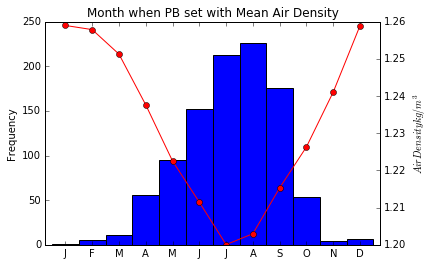

In [3]:
# The month in which PBs are set

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
annualStats.meanAirDensity.shift(-1).plot(ax=ax2,c='r',marker='o')
LB.start_date_local.dt.month.value_counts().reindex(np.arange(1,13)).plot(kind='bar', xlim=(1,12), title='Month when PB set with Mean Air Density', width=1,ax=ax1)
ax1.set_xticklabels( ['J','F','M','A','M','J','J','A','S','O','N','D'],rotation='horizontal')
ax1.set_ylabel('Frequency')
ax2.set_ylabel(r'$Air Density kg/m^3$')
fig.savefig('MonthPlotRho.png')

plt.show()



Calculate the time saving for min v max monthly average air density. Convert this into a time to complete RP assuming 40kph in high air density.

In [4]:
tDelta = (annualStats.meanAirDensity.shift(-1).min()/annualStats.meanAirDensity.shift(-1).max())**(1/3)
print('Winter time = ', pd.Timedelta(hours=10.8/40), ' Summer time = ', pd.Timedelta(hours=10.8/40*tDelta))

Winter time =  0 days 00:16:12  Summer time =  0 days 00:15:56.596889


In [5]:
annualStats

,meanT,meanP,meanH,meanAirDensity
0,12,1015,73,1.231281
1,6,1015,80,1.258959
2,6,1014,77,1.257847
3,8,1016,70,1.251254
4,11,1016,65,1.237613
5,14,1015,67,1.222517
6,17,1017,65,1.211456
7,19,1015,65,1.200051
8,18,1014,69,1.202985
9,16,1017,73,1.215323


Calculate the variation of air density due to annual changes in Temperature, Pressure and Humidity

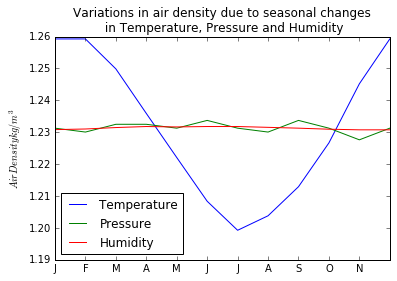

In [6]:
annualStats['dRhoBydT'] = annualStats.apply(lambda row: rhoCalc(Pressure=annualStats.meanP[0],Temp=row['meanT'],Humidity=annualStats.meanH[0],Elevation=geo.altitude.mean()), axis=1)
annualStats['dRhoBydP'] = annualStats.apply(lambda row: rhoCalc(Pressure=row['meanP'],Temp=annualStats.meanT[0],Humidity=annualStats.meanH[0],Elevation=geo.altitude.mean()), axis=1)
annualStats['dRhoBydH'] = annualStats.apply(lambda row: rhoCalc(Pressure=annualStats.meanP[0],Temp=annualStats.meanT[0],Humidity=row['meanH'],Elevation=geo.altitude.mean()), axis=1)

ax = annualStats[['dRhoBydT','dRhoBydP','dRhoBydH']].loc[1:].plot(title='Variations in air density due to seasonal changes\n in Temperature, Pressure and Humidity')
ax.legend(labels=['Temperature', 'Pressure', 'Humidity'],loc=3)
ax.set_xticks(np.arange(1,12))
ax.set_xticklabels( ['J','F','M','A','M','J','J','A','S','O','N','D'],rotation='horizontal')
ax.set_ylabel(r'$Air Density kg/m^3$')
plt.savefig('dRhodTPH.png')


Although temperature is the primary determinant of seasonal variations in air density, both atmospheric pressure and humidity can vary significantly from day to day, so it is important to consider these factors when aiming for a KOM. The next chart shows the variability of air density, measured on a particular day, for a range temperatures, pressures and humidities.

In [7]:
rangeT = [-10,40]
rangeP = [950, 1050]
rangeH = [0, 100]

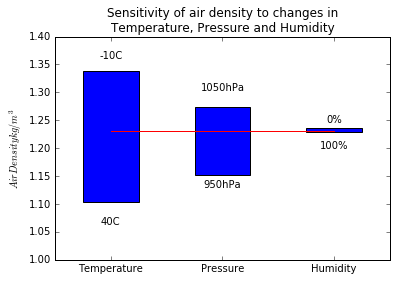

In [8]:
rangeX = pd.DataFrame()
for i in range(2):
    rangeX[i] = [\
                 rhoCalc(Pressure=annualStats.meanP[0],Temp=rangeT[i],Humidity=annualStats.meanH[0],Elevation=geo.altitude.mean()),\
                 rhoCalc(Pressure=rangeP[i],Temp=annualStats.meanT[0],Humidity=annualStats.meanH[0],Elevation=geo.altitude.mean()),\
                 rhoCalc(Pressure=annualStats.meanP[0],Temp=annualStats.meanT[0],Humidity=rangeH[i],Elevation=geo.altitude.mean())\
                  ]

    
ax = rangeX[1].subtract(rangeX[0]).plot.bar(bottom=rangeX[0], ylim=(1.0,1.4))

ax.set_xticklabels( ['Temperature','Pressure','Humidity'],rotation=0)
ax.set_ylabel(r'$Air Density kg/m^3$')
ax.set_title('Sensitivity of air density to changes in\nTemperature, Pressure and Humidity')

rects = ax.patches

# Now make some labels
labels = [str(rangeT[0])+'C', str(rangeP[1])+'hPa', str(rangeH[0])+'%']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, (height*.5 + 1.24), label, ha='center', va='bottom')

labels = [str(rangeT[1])+'C', str(rangeP[0])+'hPa', str(rangeH[1])+'%']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, (-height*.6 + 1.20), label, ha='center', va='bottom')
M = rhoCalc(Pressure=annualStats.meanP[0],Temp=annualStats.meanT[0],Humidity=annualStats.meanH[0],Elevation=geo.altitude.mean())
plt.plot([M]*3,c='r');
plt.savefig('rangeRho.png')


In [9]:
rangeX

,0,1
0,1.337935,1.103182
1,1.152128,1.273902
2,1.236009,1.229533


In [10]:
LB[LB.Pressure<980]

,activity_id,athlete_gender,athlete_id,athlete_name,athlete_profile,average_hr,average_watts,distance,effort_id,elapsed_time,moving_time,rank,start_date_local,Humidity,Pressure,Temp,Wind,WindDirn,AirDensity
168,1186007,M,112655,James Hansell,https://dgalywyr863hv.cloudfront.net/pictures/...,180.6,285.7,10779.5,17902981,00:16:10,00:16:10,168,2011-08-10 19:17:06,57.0,920.0,21.0,14.0,236.0,1.079808
687,342054579,M,1471819,Max Maggioni,https://graph.facebook.com/v2.2/592093694/pict...,NaN,275.9,10810.8,8120532241,00:17:23,00:17:23,681,2015-07-06 19:24:05,56.0,971.0,22.0,10.0,223.0,1.135887
699,341250719,M,1814759,Juan Casasbuenas,https://dgalywyr863hv.cloudfront.net/pictures/...,NaN,278.2,10799.1,8102099754,00:17:24,00:17:24,693,2015-07-06 19:24:02,56.0,970.0,22.0,10.0,223.0,1.134711
715,340554362,M,1786842,Pablo Casasbuenas,https://dgalywyr863hv.cloudfront.net/pictures/...,NaN,94.6,10812.8,8086209241,00:17:25,00:17:25,708,2015-07-06 19:24:03,56.0,970.0,22.0,10.0,223.0,1.134711
859,168011838,M,3211957,Dan Jacobs,https://dgalywyr863hv.cloudfront.net/pictures/...,78.0,269.7,10783.5,3908924994,00:17:34,00:17:34,851,2014-07-05 09:13:22,93.0,962.0,NaN,10.0,189.0,NaN


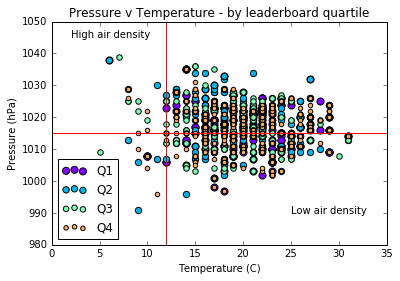

In [11]:
from matplotlib.pyplot import cm 
fig, ax = plt.subplots();
for label, df in LB.groupby((LB.index-1)//250):
    df.plot.scatter(x='Temp',y='Pressure',ax=ax,color=cm.rainbow(label/4),label='Q'+str(label+1),s=50-label*10,xlim=(0,35),ylim=(980,1050));
ax.legend(loc=3);
ax.set_title('Pressure v Temperature - by leaderboard quartile');
ax.set_ylabel('Pressure (hPa)');
ax.set_xlabel('Temperature (C)');
ax.text(2,1045,'High air density');
ax.text(25,990,'Low air density');
plt.plot((0,35),(annualStats.meanP[0], annualStats.meanP[0]), 'r-');
plt.plot((annualStats.meanT[0], annualStats.meanT[0]), (980, 1050), 'r-');
plt.savefig('PvT.png')

In [12]:
LB.AirDensity.groupby((LB.index-1)//250).mean()

0    1.196534
1    1.199373
2    1.200857
3    1.197362
Name: AirDensity, dtype: float64

In [13]:
LB.Pressure[LB.Pressure>annualStats.meanP[0]].count()

605

In [14]:
observations.describe()

/Users/Gavin/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Humidity,Pressure,Temp,Wind,WindDirn,AirDensity
count,1000.000000,1000.000000,999.000000,1000.000000,1000.000000,999.000000
mean,68.043000,1017.075000,19.879880,7.481562,177.750000,1.198532
std,12.610638,8.243017,4.384294,3.258863,99.895408,0.022347
min,40.000000,920.000000,5.000000,1.000000,1.000000,1.079808
25%,58.000000,1013.000000,NaN,5.000000,87.000000,NaN
50%,68.000000,1018.000000,NaN,7.000000,189.500000,NaN
75%,78.000000,1022.000000,NaN,10.000000,260.000000,NaN
max,100.000000,1039.000000,31.000000,19.000000,360.000000,1.286685


In [15]:
LB.loc[1]

activity_id                                                 367579592
athlete_gender                                                      M
athlete_id                                                     148510
athlete_name                                             Rob Sharland
athlete_profile     https://dgalywyr863hv.cloudfront.net/pictures/...
average_hr                                                        NaN
average_watts                                                   392.9
distance                                                      10807.4
effort_id                                                  8778121649
elapsed_time                                          0 days 00:13:57
moving_time                                           0 days 00:13:57
rank                                                                1
start_date_local                                  2015-08-12 20:31:06
Humidity                                                           62
Pressure            